## EE 541 Final Project
### Deep Convolutional Neural Networks for Classification of American Sign Language Images
#### Group 6: Anni Li, Zeli Liu

### Environment Setup

In [99]:
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
from torchvision.transforms import v2
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import math
import time
import os
import glob
import seaborn as sn
import pandas as pd
from sklearn.preprocessing import label_binarize
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import PrecisionRecallDisplay

import mediapipe as mp

In [2]:
# set up the device
if torch.cuda.is_available():
    device = torch.device('cuda')          
    print(f'Using GPU: {torch.cuda.get_device_name(0)}')
elif torch.backends.mps.is_built():
    device = 'mps' 
    print(f'using {device}')
else:
    device = torch.device('cpu')
    print(f'using {device}')

Using GPU: NVIDIA GeForce RTX 3070 Laptop GPU


### Data Processing

dataset source: https://www.kaggle.com/datasets/grassknoted/asl-alphabet/data
<br>The training dataset folder includes 87,000 images in 29 classes, while the original test dataset only includes 29 images, so we discard the provided test dataset and split the training dataset folder into training, validation, and test.

/TODO: Add noise!

#### Load the Dataset

In [3]:
# unzip the dataset
#!tar -xvzf data/asl_alphabet_train.zip -q

In [4]:
# load the dataset
folder = 'data/asl_alphabet_train'
dataset = ImageFolder(root=folder)
dataset

Dataset ImageFolder
    Number of datapoints: 87000
    Root location: data/asl_alphabet_train

#### Split the Dataset

In [5]:
# number of images in the dataset
dataset_size = len(dataset)

# define split sizes; avoid rounding errors
size_train = int(dataset_size / 10 * 7)
size_val = int(dataset_size / 10 * 1.5)
size_test = int(dataset_size / 10 * 1.5)

# split the dataset
dataset_train, dataset_val, dataset_test = random_split(dataset, 
                                                        [int(size_train), 
                                                         int(size_val), 
                                                         int(size_test)])
# double check the size
print(f'training dataset size: {len(dataset_train)}')
print(f'validation dataset size: {len(dataset_val)}')
print(f'test dataset size: {len(dataset_test)}')

training dataset size: 60900
validation dataset size: 13050
test dataset size: 13050


#### Transform Images

In [6]:
# function to normalize images
def normalize_image(tensorimage):
    image_min = tensorimage.min()
    image_max = tensorimage.max()
    tensorimage.clamp_(min=image_min, max=image_max)
    tensorimage.add_(-image_min).div_(image_max - image_min + 1e-5)
    return tensorimage

In [7]:
# function to add gaussian noise
def add_noise(tensorimage, mean, std):
    return tensorimage + torch.randn(tensorimage.size()) * std + mean

In [8]:
# for training transforms
transforms_train = v2.Compose([
    # transform to tensor
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    # normalize
    normalize_image,
    # add noise
    v2.Lambda(lambda x: add_noise(x, mean=0.0, std=0.2)),
    # randomly flip the image horizontally
    v2.RandomHorizontalFlip(),
    # randomly rotate the image up to 15 degrees
    v2.RandomRotation(15),
    # scale and crop the image
    v2.RandomResizedCrop(size=(200, 200), scale=(0.8, 1.0), antialias=True),
])

In [9]:
# for val and test transforms
transforms_valtest = v2.Compose([
    # transform to tensor
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    # normalize
    normalize_image,
    # crop the image
    v2.Resize(size=(200, 200), antialias=True)
])

In [10]:
# apply transforms to datasets
dataset_train.dataset = ImageFolder(root=folder, transform=transforms_train)

dataset_val.dataset = ImageFolder(root=folder, transform=transforms_valtest)
dataset_test.dataset = ImageFolder(root=folder, transform=transforms_valtest)

#### Data Loader

In [11]:
# dataLoader for each dataset
batch_size = 32
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

#### Data Visualization

In [12]:
# function to get class name from numeric label
def get_class(dataloader, label):
    # define the class to label dictionary
    class2label = dataloader.dataset.dataset.class_to_idx
    # revert the dictionary
    label2class = {v: k for k, v in class2label.items()}

    # return the corresponding class name and print error if label is undefined
    return label2class.get(label, 'label not found')

In [13]:
def plot_images(dataloader, num_display):
    fig = plt.figure(figsize=(16, 6))
    
    # fetch a batch
    dataiter = iter(dataloader)
    images, labels = next(dataiter)
    # batch size
    n = len(images)
    
    # define number of rows and cols in the plot
    rows = int(math.ceil(math.sqrt(num_display) / 1.5))
    cols = int(math.ceil(num_display / rows))
    
    # create plots
    for i in range(min(num_display, n)):
        ax = fig.add_subplot(rows, cols, i+1, xticks=[], yticks=[])
        # convert image to np array
        image_np = np.clip(images[i].numpy(), 0, 1)
        # transpose the array and show the image
        plt.imshow(np.transpose(image_np, (1, 2, 0)))
        # get the numeric label
        label = labels[i].item()
        # convert to class name
        classname = get_class(dataloader, label)
        ax.set_title(f'class: {classname}')
        
    plt.show()

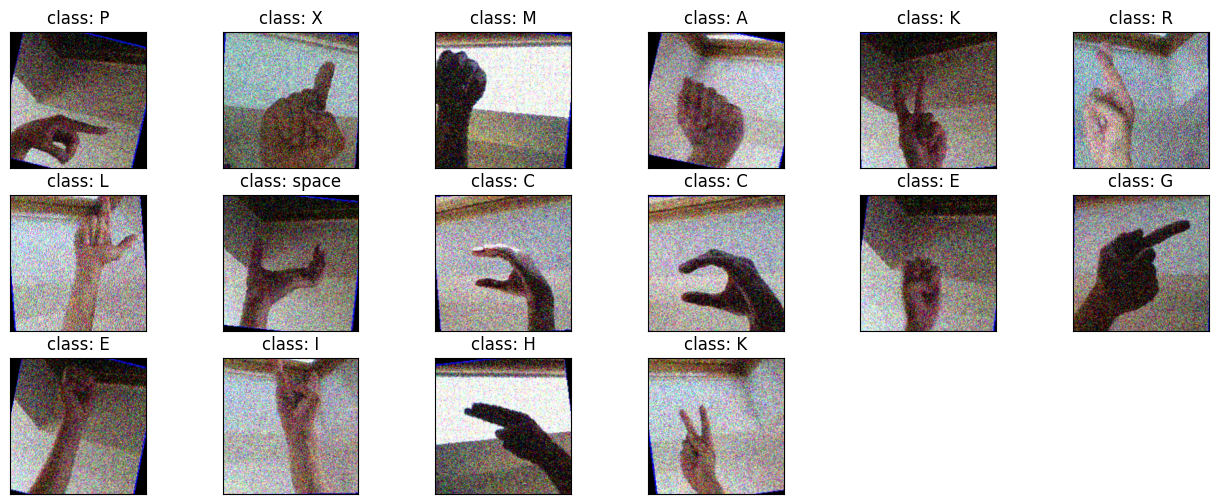

In [14]:
# see how training images look like afer transformations
plot_images(loader_train, 16)

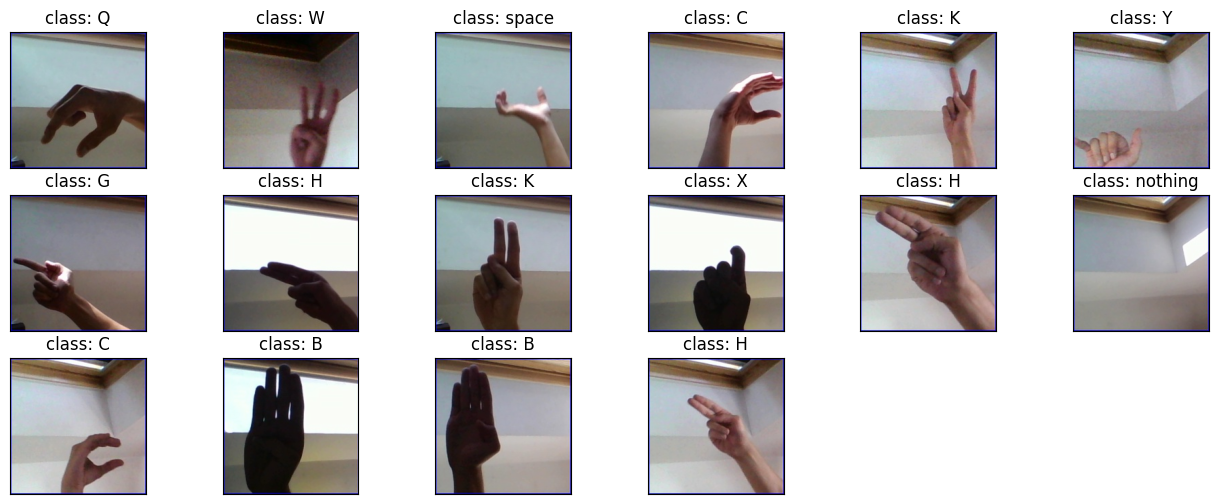

In [15]:
# see how test images look like afer transformations
plot_images(loader_test, 16)

### Model Construction

#### Baseline Model: Basic Convolutional Neural Network
\TODO: Flowchart of Model

In [16]:
class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        
        # block1, 200x200
        self.conv1a = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.bn1a = nn.BatchNorm2d(8)
        self.conv1b = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.bn1b = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        
        # block2, 100x100
        self.conv2a = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2a = nn.BatchNorm2d(32)
        self.conv2b = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2b = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        # block3, 50x50
        self.conv3a = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3a = nn.BatchNorm2d(128)
        self.conv3b = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn3b = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=5)

        self.dropout = nn.Dropout2d(0.3)
        
        # linear layers, 25x25
        self.fc1 = nn.Linear(128 * 10 * 10, 512)
        self.fc2 = nn.Linear(512, 29)
        
        self.flatten = nn.Flatten()
        
        
    def forward(self, x):
        x = F.relu(self.bn1a(self.conv1a(x)))
        x = F.relu(self.bn1b(self.conv1b(x)))
        x = self.pool1(x)
        
        x = F.relu(self.bn2a(self.conv2a(x)))
        x = F.relu(self.bn2b(self.conv2b(x)))
        x = self.pool2(x)
        
        x = F.relu(self.bn3a(self.conv3a(x)))
        x = F.relu(self.bn3b(self.conv3b(x)))
        x = self.pool3(x)
        
        x = self.dropout(x)
        
        x = self.flatten(x)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [17]:
'''
class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        
        self.pool1 = nn.MaxPool2d(2,2)
        self.pool2 = nn.MaxPool2d(2,2)
        
        self.fc1 = nn.Linear(32 * 50 * 50, 512)
        self.fc2 = nn.Linear(512, 29)
        
        self.flatten = nn.Flatten()
        
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x
'''

'\nclass BasicCNN(nn.Module):\n    def __init__(self):\n        super(BasicCNN, self).__init__()\n        \n        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)\n        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)\n        \n        self.pool1 = nn.MaxPool2d(2,2)\n        self.pool2 = nn.MaxPool2d(2,2)\n        \n        self.fc1 = nn.Linear(32 * 50 * 50, 512)\n        self.fc2 = nn.Linear(512, 29)\n        \n        self.flatten = nn.Flatten()\n        \n    def forward(self, x):\n        x = self.pool1(F.relu(self.conv1(x)))\n        x = self.pool2(F.relu(self.conv2(x)))\n        \n        x = self.flatten(x)\n        x = F.relu(self.fc1(x))\n        x = self.fc2(x)\n        \n        return x\n'

In [18]:
# function to print number of parameters
def count_params(model):
    total = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"{name}: {param.numel()}")
            total += param.numel()
    print(f'total number of trainable params: {total}')

In [19]:
model = BasicCNN()
model = model.to(device)
count_params(model)

conv1a.weight: 216
conv1a.bias: 8
bn1a.weight: 8
bn1a.bias: 8
conv1b.weight: 1152
conv1b.bias: 16
bn1b.weight: 16
bn1b.bias: 16
conv2a.weight: 4608
conv2a.bias: 32
bn2a.weight: 32
bn2a.bias: 32
conv2b.weight: 18432
conv2b.bias: 64
bn2b.weight: 64
bn2b.bias: 64
conv3a.weight: 73728
conv3a.bias: 128
bn3a.weight: 128
bn3a.bias: 128
conv3b.weight: 147456
conv3b.bias: 128
bn3b.weight: 128
bn3b.bias: 128
fc1.weight: 6553600
fc1.bias: 512
fc2.weight: 14848
fc2.bias: 29
total number of trainable params: 6815709


### Training

In [20]:
# set the loss function
criterion = nn.CrossEntropyLoss()
# set the optimizer
lr = 0.00015
optimizer = optim.Adam(model.parameters(), lr=lr)

In [21]:
num_epochs = 20

# training loop
losses_train = []
accs_train = []
losses_val = []
accs_val = []
    
best_val_acc = 0.0

for epoch in range(num_epochs):
    start_time = time.time()
    
    loss_train = 0.0
    acc_train = 0.0
    loss_val = 0.0
    acc_val = 0.0
        
    # train the model
    model.train()
    
    for inputs, labels in loader_train:
        inputs, labels = inputs.to(device), labels.to(device)
        # reset gradients
        optimizer.zero_grad()
        
        # forward
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = torch.sum(torch.eq(torch.max(outputs, axis=1).indices, labels))
        
        # backprop
        loss.backward()
        optimizer.step()

        # add up loss and accuracy
        loss_train += loss.item()
        acc_train += acc.item()
        
    # compute average loss and accuracy
    loss_train_avg = loss_train / len(loader_train)
    acc_train_avg = acc_train / len(loader_train.dataset)
    
    losses_train.append(loss_train_avg)
    accs_train.append(acc_train_avg)
    
    train_end_time = time.time()
    train_time = train_end_time - start_time
    
    print(f'epoch [{epoch+1}/{num_epochs}] - train loss: {loss_train_avg:.2f}, train acc: {acc_train_avg:.2f}, time taken: {train_time:.2f}')
    
    # validation
    model.eval()
    
    for inputs, labels in loader_val:
        inputs, labels = inputs.to(device), labels.to(device)
        # disable gradient computation
        with torch.no_grad():
            
            # forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            acc = torch.sum(torch.eq(torch.max(outputs, axis=1).indices, labels))
            
            # add up loss and accuracy
            loss_val += loss.item()
            acc_val += acc.item()
            
    # compute average loss and accuracy
    loss_val_avg = loss_val / len(loader_val)
    acc_val_avg = acc_val / len(loader_val.dataset)
    
    losses_val.append(loss_val_avg)
    accs_val.append(acc_val_avg)
    
    val_end_time = time.time()
    val_time = val_end_time - train_end_time
    
    print(f'epoch [{epoch+1}/{num_epochs}], val loss: {loss_val_avg:.2f}, val acc: {acc_val_avg:.2f}, time taken: {val_time:.2f}')
    
    # save the model with higest val acc as best model 
    if acc_val_avg > best_val_acc:
        best_val_acc = acc_val_avg
        if not os.path.exists('best_models'):
            os.makedirs('best_models')
        torch.save(model.state_dict(), 'best_models/best_model_baseline.pth')
        print(f'model saved with val acc: {best_val_acc}')
        
print('training done.')

epoch [1/20] - train loss: 2.04, train acc: 0.37, time taken: 566.08
epoch [1/20], val loss: 1.20, val acc: 0.62, time taken: 44.92
model saved with val acc: 0.6240613026819923
epoch [2/20] - train loss: 0.98, train acc: 0.68, time taken: 506.90
epoch [2/20], val loss: 0.70, val acc: 0.77, time taken: 28.00
model saved with val acc: 0.7682758620689655
epoch [3/20] - train loss: 0.66, train acc: 0.78, time taken: 504.49
epoch [3/20], val loss: 0.47, val acc: 0.84, time taken: 27.31
model saved with val acc: 0.8388505747126437
epoch [4/20] - train loss: 0.52, train acc: 0.83, time taken: 498.17
epoch [4/20], val loss: 0.41, val acc: 0.86, time taken: 27.43
model saved with val acc: 0.8599233716475095
epoch [5/20] - train loss: 0.42, train acc: 0.86, time taken: 498.60
epoch [5/20], val loss: 0.30, val acc: 0.90, time taken: 27.23
model saved with val acc: 0.8989272030651341
epoch [6/20] - train loss: 0.36, train acc: 0.88, time taken: 499.13
epoch [6/20], val loss: 0.36, val acc: 0.88, t

### Evaluation

In [22]:
def plot(num_epochs, losses_train, accs_train, losses_val, accs_val):
    plt.figure(figsize=(10, 3))
    
    # make epoch start from 1
    epochs = range(1, num_epochs+1) 
    
    # for loss curves
    plt.subplot(1, 2, 1)
    plt.plot(epochs, losses_train, label='train loss')
    plt.plot(epochs, losses_val, label='val loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
        
    # for acc curves
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accs_train, label='train accuracy')
    plt.plot(epochs, accs_val, label='val accuracy')
    plt.title('Accuracy Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy %')
    plt.legend()

    plt.show()

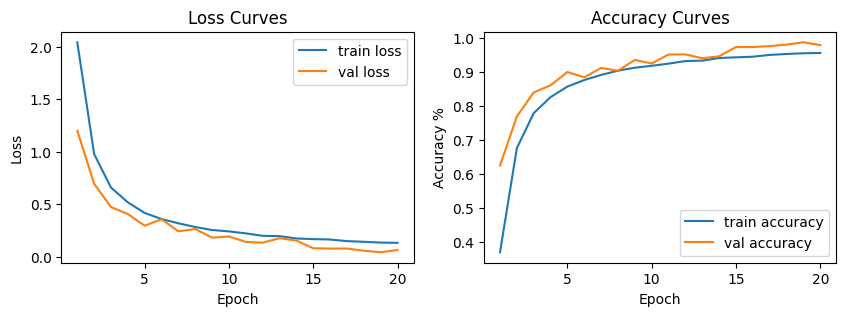

In [23]:
# plot learning curves
plot(num_epochs, losses_train, accs_train, losses_val, accs_val)

In [24]:
# test
loss_test = 0.0
acc_test = 0.0
# load the best model
model.load_state_dict(torch.load('best_models/best_model_baseline.pth'))
model = model.to(device)

model.eval()

for inputs, labels in loader_test:
    inputs, labels = inputs.to(device), labels.to(device)
    
    # disable gradient computation
    with torch.no_grad():
        
        # forward
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = torch.sum(torch.eq(torch.max(outputs, axis=1).indices, labels))
        
        # add up loss and acc
        loss_test += loss.item()
        acc_test += acc.item()

# get average loss and acc
loss_test_avg = loss_test / len(loader_test)
acc_test_avg = acc_test / len(loader_test.dataset)

print(f'test loss: {loss_test_avg:.2f}, test acc: {acc_test_avg:.2f}')

test loss: 0.05, test acc: 0.99


### Use Pre-trained MediaPipe Hands Model to Detect Skeleton of Hands

#### Process Whole Dataset by MediaPipe

In [25]:
# function to process images by mediapipe
def process_images(input_folder, output_folder):
    # create mediapipe model
    mp_hands = mp.solutions.hands
    hands = mp_hands.Hands(static_image_mode=True, 
                           max_num_hands=1, 
                           min_detection_confidence=0.5)
    
    # go through each subfolder
    for class_folder in os.listdir(input_folder):
        input_class_path = os.path.join(input_folder, class_folder)
        output_class_path = os.path.join(output_folder, class_folder)

        # create output subfolder
        if not os.path.exists(output_class_path):
            os.makedirs(output_class_path)

        for image_path in glob.glob(os.path.join(input_class_path, '*.jpg')):
            # read and convert the image to rgb
            image = Image.open(image_path)
            image_rgb = np.array(image.convert('RGB'))

            # process through mediapipe model
            results = hands.process(image_rgb)
            if results.multi_hand_landmarks:
                # drop the marks on image
                for hand_landmarks in results.multi_hand_landmarks:
                    mp.solutions.drawing_utils.draw_landmarks(image_rgb, hand_landmarks, mp_hands.HAND_CONNECTIONS)

            # save the output image
            image_mp = Image.fromarray(image_rgb)
            base_name = os.path.basename(image_path)
            image_mp.save(os.path.join(output_class_path, base_name))

In [26]:
input_folder = 'data/asl_alphabet_train'
output_folder = 'data/asl_alphabet_train_mp'
process_images(input_folder, output_folder)

In [27]:
# load the dataset
folder_mp = 'data/asl_alphabet_train_mp'
dataset_mp = ImageFolder(root=folder)
dataset_mp

Dataset ImageFolder
    Number of datapoints: 87000
    Root location: data/asl_alphabet_train

In [28]:
# number of images in the dataset
dataset_size_mp = len(dataset_mp)

# define split sizes; avoid rounding errors
size_train_mp = int(dataset_size_mp / 10 * 7)
size_val_mp = int(dataset_size_mp / 10 * 1.5)
size_test_mp = int(dataset_size_mp / 10 * 1.5)

# split the dataset
dataset_train_mp, dataset_val_mp, dataset_test_mp = random_split(dataset_mp, 
                                                        [int(size_train_mp), 
                                                         int(size_val_mp), 
                                                         int(size_test_mp)])
# double check the size
print(f'training dataset size: {len(dataset_train_mp)}')
print(f'validation dataset size: {len(dataset_val_mp)}')
print(f'test dataset size: {len(dataset_test_mp)}')

training dataset size: 60900
validation dataset size: 13050
test dataset size: 13050


In [29]:
# for training transforms
transforms_train_mp = v2.Compose([
    # transform to tensor
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    # normalize
    normalize_image,
    # add noise
    v2.Lambda(lambda x: add_noise(x, mean=0.0, std=0.2)),
    # randomly flip the image horizontally
    v2.RandomHorizontalFlip(),
    # randomly rotate the image up to 15 degrees
    v2.RandomRotation(15),
    # scale and crop the image
    v2.RandomResizedCrop(size=(200, 200), scale=(0.8, 1.0), antialias=True)
])

In [30]:
# for val and test transforms
transforms_valtest_mp = v2.Compose([
    # transform to tensor
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    # normalize
    normalize_image,
    # crop the image
    v2.Resize(size=(200, 200), antialias=True)
])

In [31]:
# apply transforms to datasets
dataset_train_mp.dataset = ImageFolder(root=folder_mp, transform=transforms_train_mp)

dataset_val_mp.dataset = ImageFolder(root=folder_mp, transform=transforms_valtest_mp)
dataset_test_mp.dataset = ImageFolder(root=folder_mp, transform=transforms_valtest_mp)

In [32]:
# dataLoader for each dataset
batch_size_mp = 32
loader_train_mp = DataLoader(dataset_train_mp, batch_size=batch_size_mp, shuffle=True)
loader_val_mp = DataLoader(dataset_val_mp, batch_size=batch_size_mp, shuffle=False)
loader_test_mp = DataLoader(dataset_test_mp, batch_size=batch_size_mp, shuffle=False)

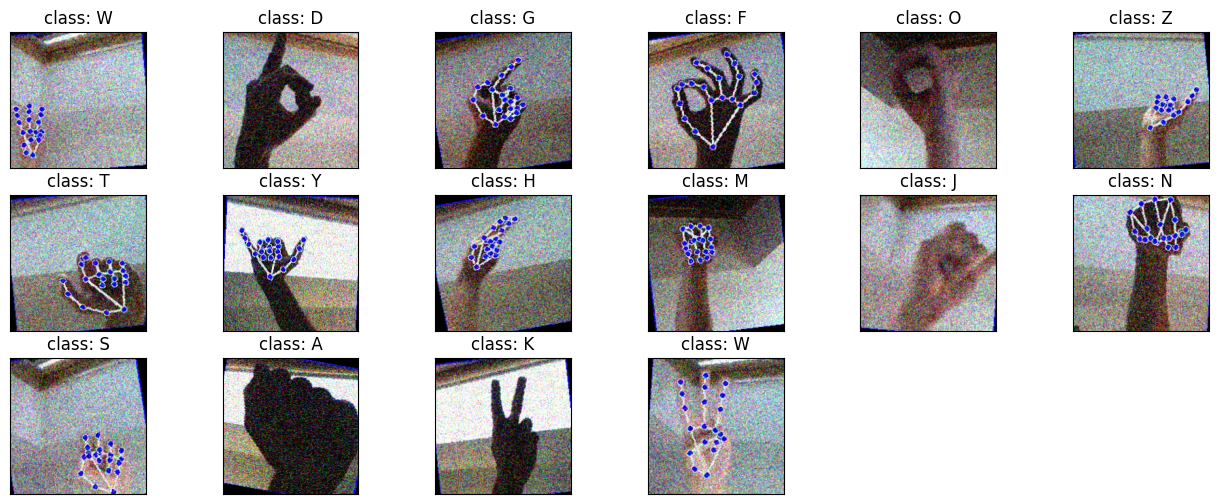

In [33]:
# see how training images look like afer transformations
plot_images(loader_train_mp, 16)

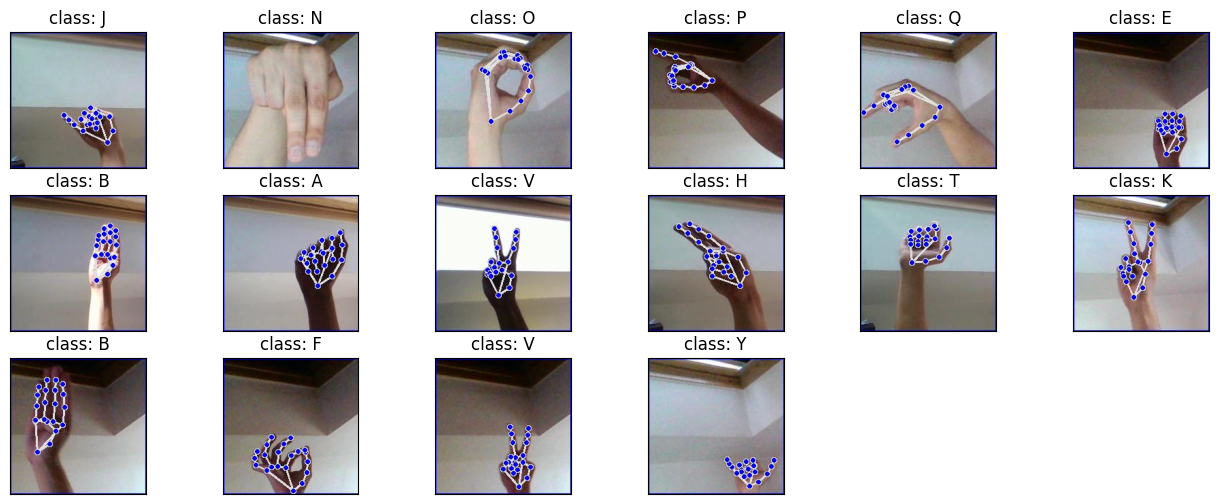

In [34]:
# see how test images look like afer transformations
plot_images(loader_test_mp, 16)

In [35]:
model_mp = BasicCNN()
model_mp = model_mp.to(device)

In [36]:
# set the loss function
criterion_mp = nn.CrossEntropyLoss()
# set the optimizer
lr_mp = 0.00015
optimizer_mp = optim.Adam(model_mp.parameters(), lr=lr_mp)

In [37]:
num_epochs_mp = 20

# training loop
losses_train_mp = []
accs_train_mp = []
losses_val_mp = []
accs_val_mp = []
    
best_val_acc_mp = 0.0

for epoch in range(num_epochs_mp):
    start_time = time.time()
    
    loss_train = 0.0
    acc_train = 0.0
    loss_val = 0.0
    acc_val = 0.0
        
    # train the model
    model_mp.train()
    
    for inputs, labels in loader_train_mp:
        inputs, labels = inputs.to(device), labels.to(device)
        # reset gradients
        optimizer_mp.zero_grad()
        
        # forward
        outputs = model_mp(inputs)
        loss = criterion_mp(outputs, labels)
        acc = torch.sum(torch.eq(torch.max(outputs, axis=1).indices, labels))
        
        # backprop
        loss.backward()
        optimizer_mp.step()

        # add up loss and accuracy
        loss_train += loss.item()
        acc_train += acc.item()
        
    # compute average loss and accuracy
    loss_train_avg = loss_train / len(loader_train_mp)
    acc_train_avg = acc_train / len(loader_train_mp.dataset)
    
    losses_train_mp.append(loss_train_avg)
    accs_train_mp.append(acc_train_avg)
    
    train_end_time = time.time()
    train_time = train_end_time - start_time
    
    print(f'epoch [{epoch+1}/{num_epochs_mp}] - train loss: {loss_train_avg:.2f}, train acc: {acc_train_avg:.2f}, time taken: {train_time:.2f}')
    
    # validation
    model_mp.eval()
    
    for inputs, labels in loader_val_mp:
        inputs, labels = inputs.to(device), labels.to(device)
        # disable gradient computation
        with torch.no_grad():
            
            # forward
            outputs = model_mp(inputs)
            loss = criterion_mp(outputs, labels)
            acc = torch.sum(torch.eq(torch.max(outputs, axis=1).indices, labels))
            
            # add up loss and accuracy
            loss_val += loss.item()
            acc_val += acc.item()
            
    # compute average loss and accuracy
    loss_val_avg = loss_val / len(loader_val_mp)
    acc_val_avg = acc_val / len(loader_val_mp.dataset)
    
    losses_val_mp.append(loss_val_avg)
    accs_val_mp.append(acc_val_avg)
    
    val_end_time = time.time()
    val_time = val_end_time - train_end_time
    
    print(f'epoch [{epoch+1}/{num_epochs_mp}], val loss: {loss_val_avg:.2f}, val acc: {acc_val_avg:.2f}, time taken: {val_time:.2f}')
    
    # save the model with higest val acc as best model 
    if acc_val_avg > best_val_acc_mp:
        best_val_acc_mp = acc_val_avg
        torch.save(model_mp.state_dict(), 'best_models/best_model_skeleton.pth')
        print(f'model saved with val acc: {best_val_acc_mp}')
        
print('training done.')

epoch [1/20] - train loss: 2.07, train acc: 0.36, time taken: 691.54
epoch [1/20], val loss: 1.19, val acc: 0.63, time taken: 74.51
model saved with val acc: 0.6250574712643678
epoch [2/20] - train loss: 1.04, train acc: 0.65, time taken: 498.25
epoch [2/20], val loss: 0.72, val acc: 0.75, time taken: 26.72
model saved with val acc: 0.7519540229885058
epoch [3/20] - train loss: 0.69, train acc: 0.77, time taken: 497.14
epoch [3/20], val loss: 0.48, val acc: 0.84, time taken: 26.09
model saved with val acc: 0.8403831417624521
epoch [4/20] - train loss: 0.51, train acc: 0.83, time taken: 495.83
epoch [4/20], val loss: 0.33, val acc: 0.89, time taken: 27.10
model saved with val acc: 0.8918007662835249
epoch [5/20] - train loss: 0.41, train acc: 0.86, time taken: 498.30
epoch [5/20], val loss: 0.27, val acc: 0.92, time taken: 26.89
model saved with val acc: 0.917088122605364
epoch [6/20] - train loss: 0.34, train acc: 0.88, time taken: 498.48
epoch [6/20], val loss: 0.27, val acc: 0.92, ti

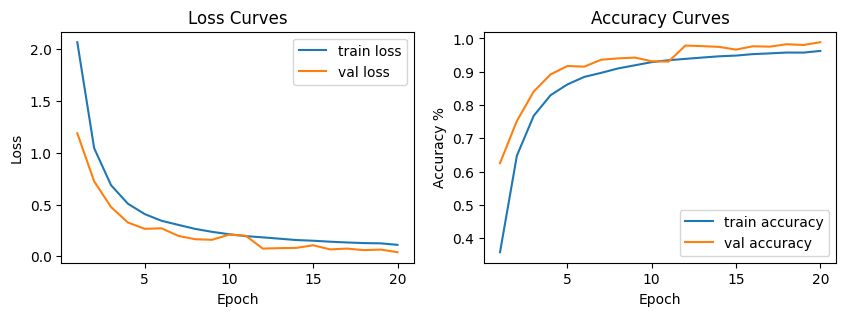

In [38]:
# plot learning curves
plot(num_epochs_mp, losses_train_mp, accs_train_mp, losses_val_mp, accs_val_mp)

In [39]:
# test
loss_test_mp = 0.0
acc_test_mp = 0.0
# load the best model
model_mp.load_state_dict(torch.load('best_models/best_model_skeleton.pth'))
model_mp = model_mp.to(device)

model_mp.eval()

for inputs, labels in loader_test_mp:
    inputs, labels = inputs.to(device), labels.to(device)
    
    # disable gradient computation
    with torch.no_grad():
        
        # forward
        outputs = model_mp(inputs)
        loss = criterion_mp(outputs, labels)
        acc = torch.sum(torch.eq(torch.max(outputs, axis=1).indices, labels))
        
        # add up loss and acc
        loss_test_mp += loss.item()
        acc_test_mp += acc.item()

# get average loss and acc
loss_test_avg_mp = loss_test_mp / len(loader_test_mp)
acc_test_avg_mp = acc_test_mp / len(loader_test_mp.dataset)

print(f'test loss: {loss_test_avg_mp:.2f}, test acc: {acc_test_avg_mp:.2f}')

test loss: 0.04, test acc: 0.99


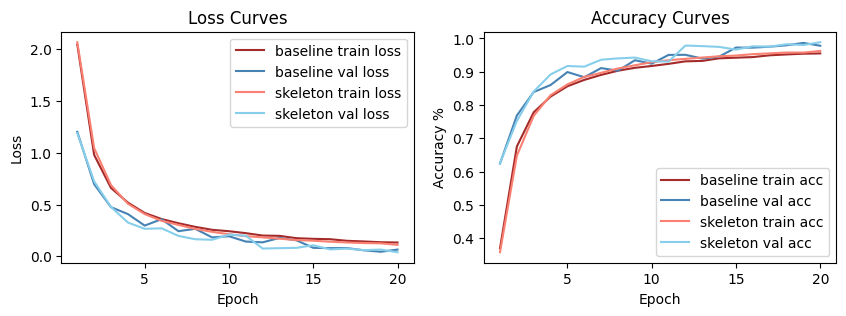

In [40]:
plt.figure(figsize=(10, 3))
epochs = range(1, num_epochs+1) 

plt.subplot(1, 2, 1)
plt.plot(epochs, losses_train, label='baseline train loss', color='brown')
plt.plot(epochs, losses_val, label='baseline val loss', color='steelblue')
plt.plot(epochs, losses_train_mp, label='skeleton train loss', color='salmon')
plt.plot(epochs, losses_val_mp, label='skeleton val loss', color='skyblue')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
        
plt.subplot(1, 2, 2)
plt.plot(epochs, accs_train, label='baseline train acc', color='brown')
plt.plot(epochs, accs_val, label='baseline val acc', color='steelblue')
plt.plot(epochs, accs_train_mp, label='skeleton train acc', color='salmon')
plt.plot(epochs, accs_val_mp, label='skeleton val acc', color='skyblue')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy %')
plt.legend()

plt.show()

In [108]:
print(f'test accuracy for baseline model: {acc_test_avg}')
print(f'test accuracy for skeleton model: {acc_test_avg_mp}')

test accuracy for baseline model: 0.9859003831417624
test accuracy for skeleton model: 0.9871264367816092


\TODO: Confusion Matrix

#### Confusion Matrix

In [81]:
model = BasicCNN()
model.load_state_dict(torch.load('best_models/best_model_baseline.pth'))
model = model.to(device)

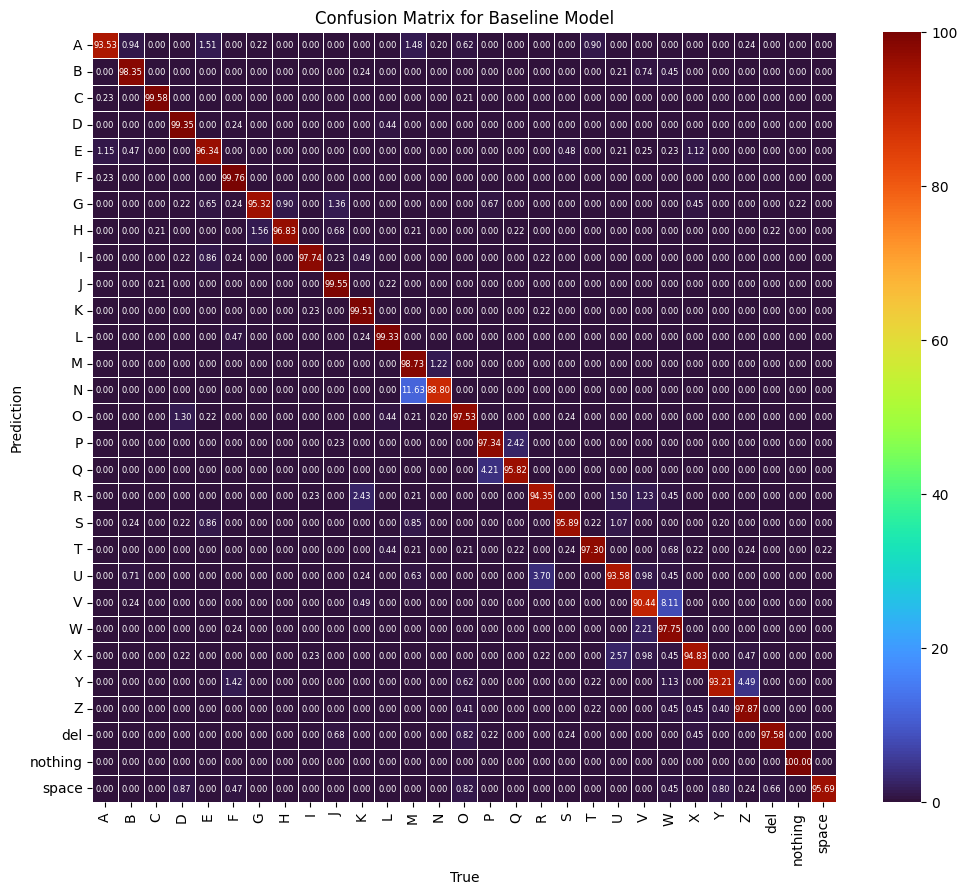

In [82]:
num_classes = 29
classes = [get_class(loader_test, i) for i in range(num_classes)]
confusion_matrix = np.zeros((num_classes, num_classes))
count = np.zeros((num_classes))
for inputs, labels in loader_test:
    inputs, labels = inputs.to(device), labels.to(device)
    # disable gradient computation
    with torch.no_grad():
        # forward
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # prediction and create confusion matrix
        for true, pred in zip(labels, preds):
            confusion_matrix[true, pred] += 1
            count[true.long()] += 1
            
plt.figure(figsize=[12,10])
# create dataframe to hold the matrix
df = pd.DataFrame(100 * confusion_matrix / count)
# create heatmap
ax = sn.heatmap(df, vmin=0, vmax=100, cmap='turbo', annot=True, fmt='.2f', annot_kws={'size':6}, linewidths=0.5, xticklabels=classes, yticklabels=classes)
ax.set_xlabel('True')
ax.set_ylabel('Prediction')
ax.set_title('Confusion Matrix for Baseline Model')
plt.show()

In [74]:
model_mp = BasicCNN()
model_mp.load_state_dict(torch.load('best_models/best_model_skeleton.pth'))
model_mp = model_mp.to(device)

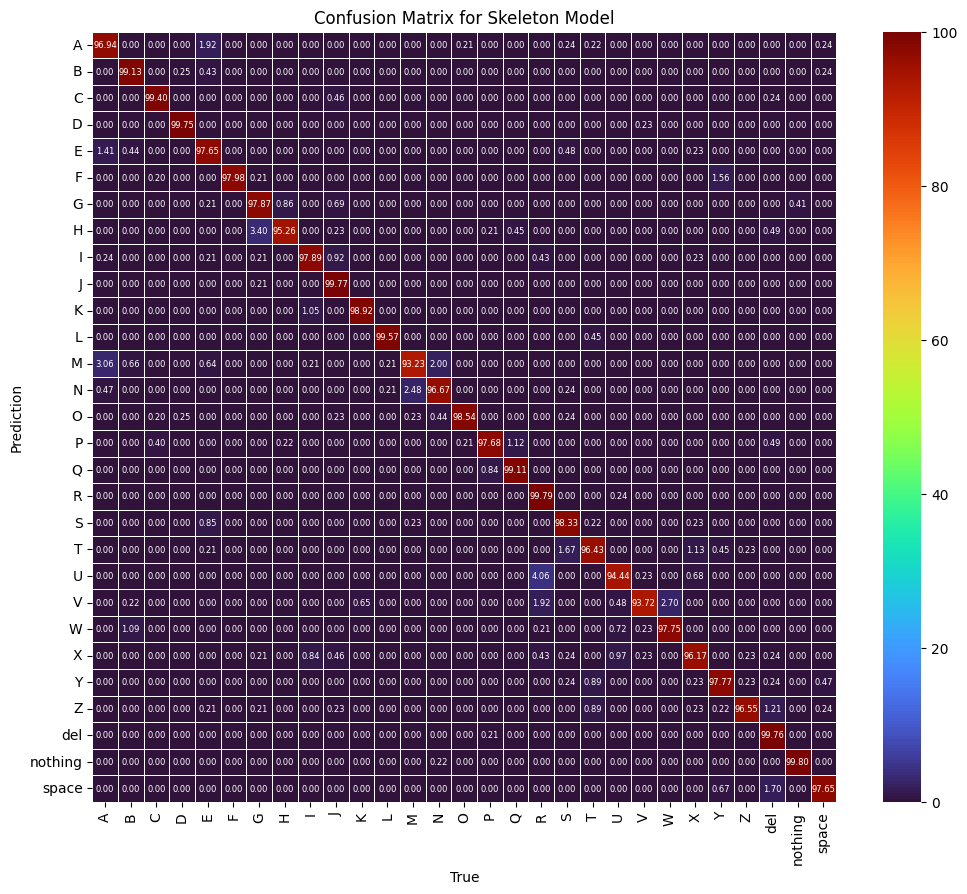

In [76]:
num_classes = 29
classes_mp = [get_class(loader_test_mp, i) for i in range(num_classes)]
confusion_matrix_mp = np.zeros((num_classes, num_classes))
count_mp = np.zeros((num_classes))
for inputs, labels in loader_test_mp:
    inputs, labels = inputs.to(device), labels.to(device)
    # disable gradient computation
    with torch.no_grad():
        # forward
        outputs = model_mp(inputs)
        _, preds = torch.max(outputs, 1)

        # prediction and create confusion matrix
        for true, pred in zip(labels, preds):
            confusion_matrix_mp[true, pred] += 1
            count_mp[true.long()] += 1
            
plt.figure(figsize=[12,10])
# create dataframe to hold the matrix
df_mp = pd.DataFrame(100 * confusion_matrix_mp / count_mp)
# create heatmap
ax = sn.heatmap(df_mp, vmin=0, vmax=100, cmap='turbo', annot=True, fmt='.2f', annot_kws={'size':6}, linewidths=0.5, xticklabels=classes, yticklabels=classes)
ax.set_xlabel('True')
ax.set_ylabel('Prediction')
ax.set_title('Confusion Matrix for Skeleton Model')
plt.show()


In [103]:
# calculate precision and recall
matrix = np.array(df)
# calculate TP, FP, FN and store in arrays
TP = np.diag(matrix)
FP = np.sum(matrix, axis=0) - TP
FN = np.sum(matrix, axis=1) - TP
# calculate precision and recall
precision = TP / (TP + FP)
recall = TP / (TP + FN)
print('Precision and Recall for each class of Baseline Model')
for i in range(num_classes):
    print(f"class {i}: precision = {precision[i]:.2f}, recall = {recall[i]:.2f}")

Precision and Recall for each class of Baseline Model
class 0: precision = 0.98, recall = 0.94
class 1: precision = 0.97, recall = 0.98
class 2: precision = 1.00, recall = 1.00
class 3: precision = 0.97, recall = 0.99
class 4: precision = 0.96, recall = 0.96
class 5: precision = 0.97, recall = 1.00
class 6: precision = 0.98, recall = 0.95
class 7: precision = 0.99, recall = 0.97
class 8: precision = 0.99, recall = 0.98
class 9: precision = 0.97, recall = 1.00
class 10: precision = 0.96, recall = 1.00
class 11: precision = 0.98, recall = 0.99
class 12: precision = 0.86, recall = 0.99
class 13: precision = 0.98, recall = 0.88
class 14: precision = 0.96, recall = 0.97
class 15: precision = 0.95, recall = 0.97
class 16: precision = 0.97, recall = 0.96
class 17: precision = 0.96, recall = 0.94
class 18: precision = 0.99, recall = 0.96
class 19: precision = 0.98, recall = 0.97
class 20: precision = 0.94, recall = 0.93
class 21: precision = 0.93, recall = 0.91
class 22: precision = 0.88, reca

In [104]:
# calculate precision and recall
matrix_mp = np.array(df_mp)
# calculate TP, FP, FN and store in arrays
TP_mp = np.diag(matrix_mp)
FP_mp = np.sum(matrix_mp, axis=0) - TP_mp
FN_mp = np.sum(matrix_mp, axis=1) - TP_mp
# calculate precision and recall
precision_mp = TP_mp / (TP_mp + FP_mp)
recall_mp = TP_mp / (TP_mp + FN_mp)
print('Precision and Recall for each class of Skeleton Model')
for i in range(num_classes):
    print(f"class {i}: precision = {precision_mp[i]:.2f}, recall = {recall_mp[i]:.2f}")

Precision and Recall for each class of Skeleton Model
class 0: precision = 0.95, recall = 0.97
class 1: precision = 0.98, recall = 0.99
class 2: precision = 0.99, recall = 0.99
class 3: precision = 1.00, recall = 1.00
class 4: precision = 0.95, recall = 0.97
class 5: precision = 1.00, recall = 0.98
class 6: precision = 0.96, recall = 0.98
class 7: precision = 0.99, recall = 0.95
class 8: precision = 0.98, recall = 0.98
class 9: precision = 0.97, recall = 1.00
class 10: precision = 0.99, recall = 0.99
class 11: precision = 1.00, recall = 1.00
class 12: precision = 0.97, recall = 0.93
class 13: precision = 0.97, recall = 0.97
class 14: precision = 1.00, recall = 0.98
class 15: precision = 0.99, recall = 0.98
class 16: precision = 0.98, recall = 0.99
class 17: precision = 0.93, recall = 1.00
class 18: precision = 0.97, recall = 0.98
class 19: precision = 0.97, recall = 0.96
class 20: precision = 0.98, recall = 0.95
class 21: precision = 0.99, recall = 0.94
class 22: precision = 0.97, reca

In [96]:
# get true label and predicted labels as one-hot
y_test = []
y_score = []
model.eval()
for inputs, labels in loader_test:
    inputs, labels = inputs.to(device), labels.to(device)
    with torch.no_grad():
        outputs = model(inputs)
        preds = torch.softmax(outputs, dim=1)
        y_score.append(preds)
        y_test.append(labels)
# Concatenate all the collected data
y_score = torch.cat(y_score).cpu().numpy()
y_test = torch.cat(y_test).cpu().numpy()
y_test = [get_class(loader_test, i) for i in y_test]
y_test = label_binarize(y_test, classes=classes)

In [97]:
precision = dict()
recall = dict()
average_precision = dict()
for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])

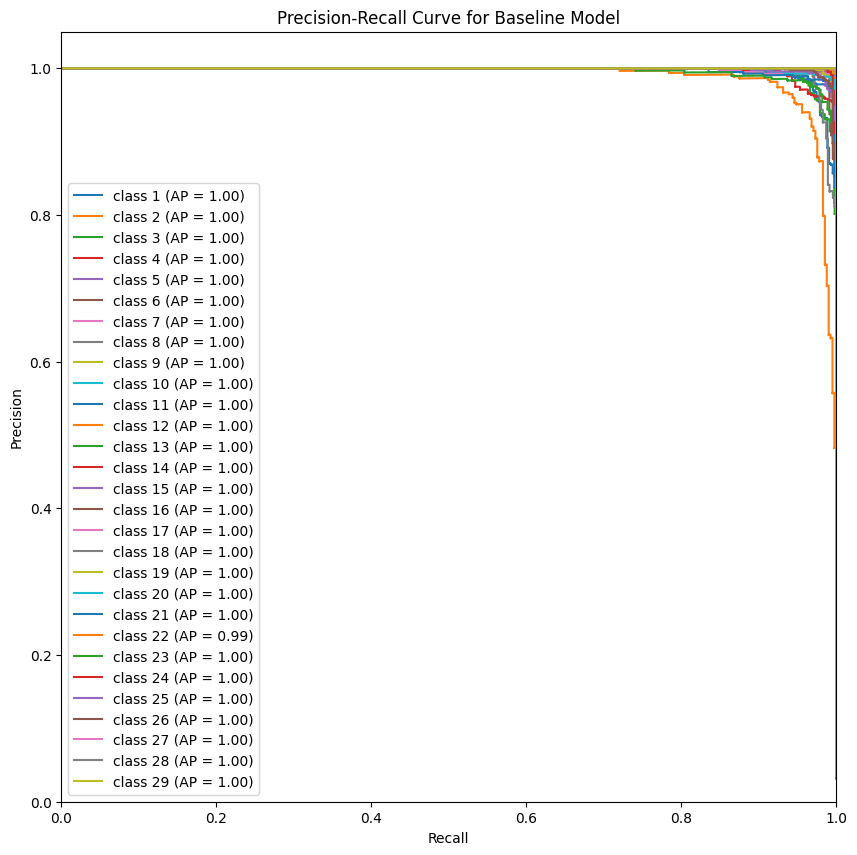

In [102]:
_, ax = plt.subplots(figsize=(10, 10))
for i in range(num_classes):
    display = PrecisionRecallDisplay(
        recall=recall[i],
        precision=precision[i],
        average_precision=average_precision[i])
    display.plot(ax=ax, name=f'class {i+1}')
ax.set_xlim([0.0, 1])
ax.set_ylim([0.0, 1.05])
ax.legend()
ax.set_title('Precision-Recall Curve for Baseline Model')
plt.show()

In [105]:
# get true label and predicted labels as one-hot
y_test_mp = []
y_score_mp = []
model_mp.eval()
for inputs, labels in loader_test_mp:
    inputs, labels = inputs.to(device), labels.to(device)
    with torch.no_grad():
        outputs = model_mp(inputs)
        preds = torch.softmax(outputs, dim=1)
        y_score_mp.append(preds)
        y_test_mp.append(labels)
# Concatenate all the collected data
y_score_mp = torch.cat(y_score_mp).cpu().numpy()
y_test_mp = torch.cat(y_test_mp).cpu().numpy()
y_test_mp = [get_class(loader_test_mp, i) for i in y_test_mp]
y_test_mp = label_binarize(y_test_mp, classes=classes)

In [106]:
precision_mp = dict()
recall_mp = dict()
average_precision_mp = dict()
for i in range(num_classes):
    precision_mp[i], recall_mp[i], _ = precision_recall_curve(y_test_mp[:, i], y_score_mp[:, i])
    average_precision_mp[i] = average_precision_score(y_test_mp[:, i], y_score_mp[:, i])

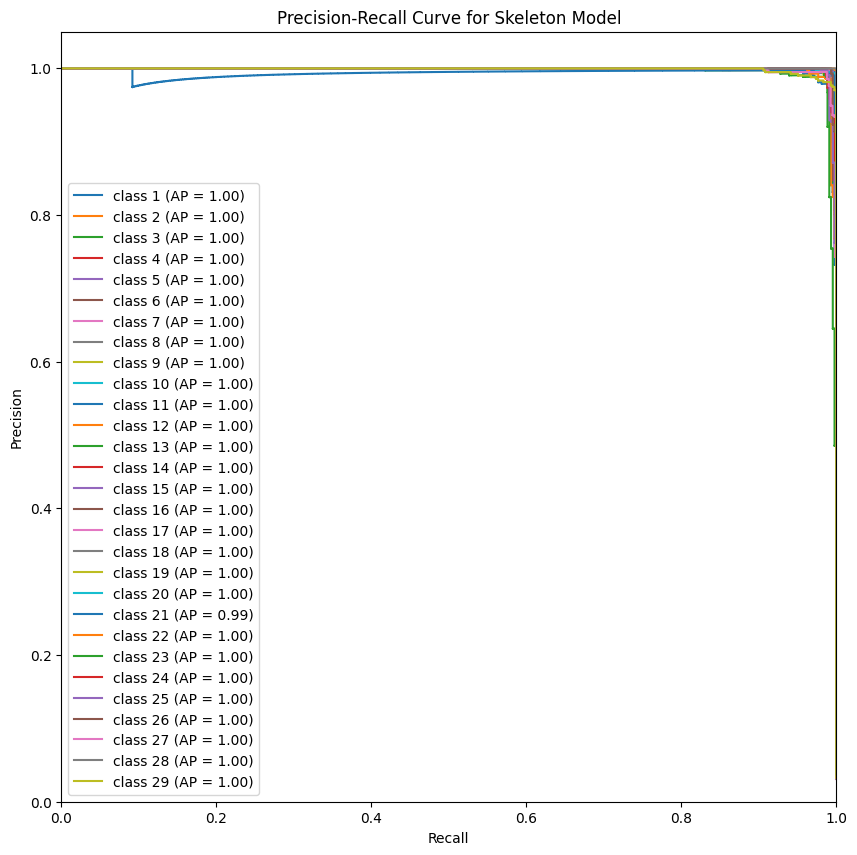

In [107]:
_, ax = plt.subplots(figsize=(10, 10))
for i in range(num_classes):
    display = PrecisionRecallDisplay(
        recall=recall_mp[i],
        precision=precision_mp[i],
        average_precision=average_precision_mp[i])
    display.plot(ax=ax, name=f'class {i+1}')
ax.set_xlim([0.0, 1])
ax.set_ylim([0.0, 1.05])
ax.legend()
ax.set_title('Precision-Recall Curve for Skeleton Model')
plt.show()

### Discussion